In [33]:
import pandas as pd
import numpy as np
import os

In [75]:
# DID NOT END UP USING LATIN HYPERCUBE SAMPLING
import numpy as np
from scipy.stats import qmc

def latin_hypercube_sampling(num_samples, bounds):
    sampler = qmc.LatinHypercube(d=len(bounds))
    sample = sampler.random(n=num_samples)
    scaled_sample = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
    return scaled_sample

# Define bounds for each parameter: means from 0.1 to 0.5, stds from 0.05 to 0.25
bounds = np.array([[0.1, 0.5], [0.05, 0.25]])

samples = latin_hypercube_sampling(10, bounds)
samples


array([[0.45507082, 0.13189412],
       [0.32498177, 0.12422746],
       [0.27249323, 0.21023607],
       [0.13679007, 0.18623904],
       [0.23268776, 0.15688122],
       [0.19813413, 0.05107029],
       [0.48784132, 0.19589471],
       [0.34457683, 0.07292075],
       [0.14234308, 0.24758644],
       [0.39602532, 0.10139045]])

In [2]:
import re
def read_matrix_from_line(line):
    try:
        # Split the line by the string ' {{matrix: '
        parts = line.split(' {{matrix: ')
        if len(parts) == 2:
            index = int(parts[0])
            matrix_str = parts[1].rstrip('}}\n')  # Remove the closing '}}' and newline character
            # Remove leading and trailing whitespace, and leading/trailing square brackets
            matrix_str = matrix_str.strip('[] \n')
            # Split the string into rows
            rows = re.split(r'\]\[', matrix_str)
            # Parse each row into a list of floats
            matrix = [[float(val) for val in row.split()] for row in rows]
            return index, matrix
    except (ValueError, SyntaxError):
        pass
    return None, None

# Open the file and read the matrices
matrices = []
with open('bank-ratios.csv', 'r') as file:
    for line in file:
        index, matrix = read_matrix_from_line(line)
        if matrix:
            matrices.append([index, matrix])


In [9]:
#matrix: idx, idx #, row(bank), col (values)
#idx 6: credit card failure
#idx 7: liquidity indicator
def count_failures(idx, matrices):
    '''Returns the parameter values and avg bank failure numbers across 5 runs of the idx-th parameter sweep simulation
    '''
    start_idx = 1500*idx
    num_credit_failures = 0
    num_liquidity_failures = 0
    for i in range(start_idx, start_idx+300):
        #number of banks
        for j in range(0, 10):
            num_credit_failures += matrices[i][1][j][6]
            num_liquidity_failures += matrices[i][1][j][7]
    mean_withdrawl_p = matrices[start_idx][1][0][0]
    std_withdrawl_p = matrices[start_idx][1][0][1]
    min_reserves_ratio = matrices[start_idx][1][0][2]
    num_credit_failures /= 5
    num_liquidity_failures /=5
    return mean_withdrawl_p, std_withdrawl_p, min_reserves_ratio, num_credit_failures, num_liquidity_failures
    

In [10]:
#There should be 36 parameter combinations
data = []
for i in range(0, 36):
    wp, sp, rr, cf, lf = count_failures(i, matrices=matrices)
    data.append([wp,sp,rr,cf,lf])
data=np.array(data)


In [58]:
means = [row[0] for row in data]
stds = [row[1] for row in data]
reserve_ratios = [row[2] for row in data]
num_credit_failures = [row[3] for row in data]
num_liquidity_failures = [row[4] for row in data]

means_03 = [row[0] for row in data if row[2] == 0.03]
stds_03 = [row[1] for row in data if row[2] == 0.03]
num_liquidity_failures_03 = [row[4] for row in data if row[2] == 0.03]

means_06 = [row[0] for row in data if row[2] == 0.06]
stds_06 = [row[1] for row in data if row[2] == 0.06]
num_liquidity_failures_06 = [row[4] for row in data if row[2] == 0.06]


In [84]:
dt = {
    'Mean': means,
    'Standard Deviation': stds,
    'Minimum Reserve Ratios': reserve_ratios,
    'Liquidity Failure': num_liquidity_failures
}
df = pd.DataFrame(dt)
df = df.round(2)

styled_df = df.style.set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'border-color': 'white'
})
styled_df = styled_df.format("{:.2f}")
pd.set_option('display.precision', 2)
styled_df

,Mean,Standard Deviation,Minimum Reserve Ratios,Liquidity Failure
0,10.00,5.00,0.03,179.20
1,10.00,5.00,0.06,0.00
2,10.00,15.00,0.03,15.40
3,10.00,15.00,0.06,0.00
4,10.00,20.00,0.03,333.20
5,10.00,20.00,0.06,0.00
6,20.00,5.00,0.03,446.40
7,20.00,5.00,0.06,0.00
8,20.00,15.00,0.03,464.20
9,20.00,15.00,0.06,0.00


In [45]:
import matplotlib.pyplot as plt

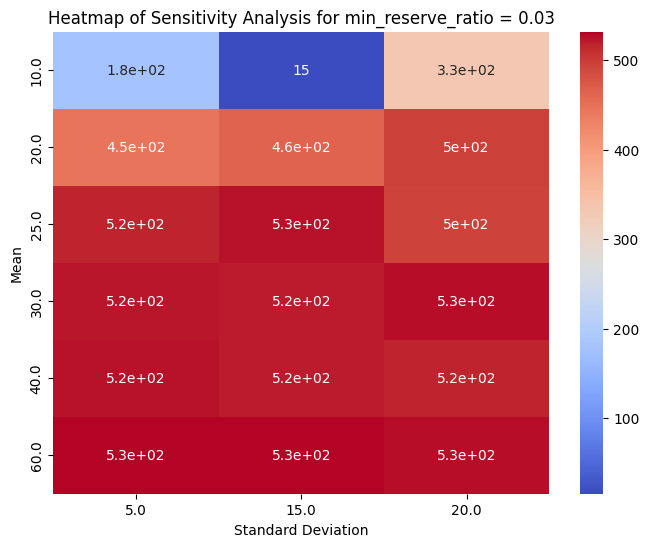

In [85]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Example data
dt = {
    'Mean': means_03,
    'Standard Deviation': stds_03,
    'Liquidity Failure': num_liquidity_failures_03
}
df = pd.DataFrame(dt)
df = df.round(2)
# Pivot the data for the heatmap
pivot_table = df.pivot(index='Mean', columns='Standard Deviation', values='Liquidity Failure')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm")
plt.title('Heatmap of Sensitivity Analysis for min_reserve_ratio = 0.03')
plt.show()

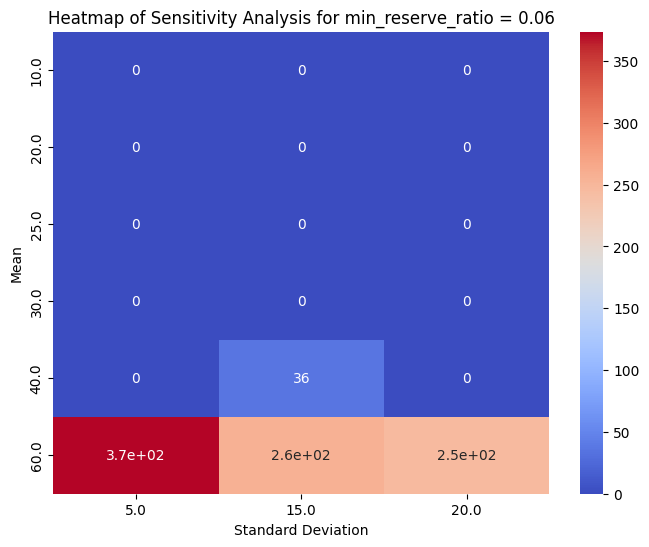

In [67]:
dt = {
    'Mean': means_06,
    'Standard Deviation': stds_06,
    'Liquidity Failure': num_liquidity_failures_06
}
df = pd.DataFrame(dt)

# Pivot the data for the heatmap
pivot_table = df.pivot(index='Mean', columns='Standard Deviation', values='Liquidity Failure')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm")
plt.title('Heatmap of Sensitivity Analysis for min_reserve_ratio = 0.06')
plt.show()

<Figure size 1200x1200 with 0 Axes>

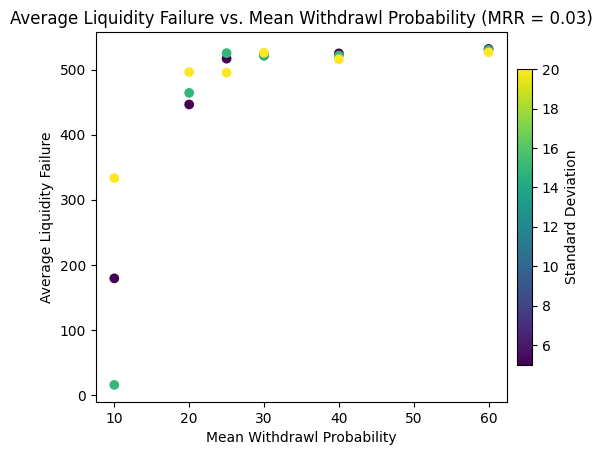

<Figure size 1200x1200 with 0 Axes>

In [100]:
plt.scatter(means_03, num_liquidity_failures_03, c=stds_03, cmap='viridis')
plt.xlabel('Mean Withdrawl Probability')
plt.ylabel('Average Liquidity Failure')
plt.title('Average Liquidity Failure vs. Mean Withdrawl Probability (MRR = 0.03)')
cbar = plt.colorbar(aspect=20, shrink=0.8, pad=0.02)
cbar.set_label('Standard Deviation')
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

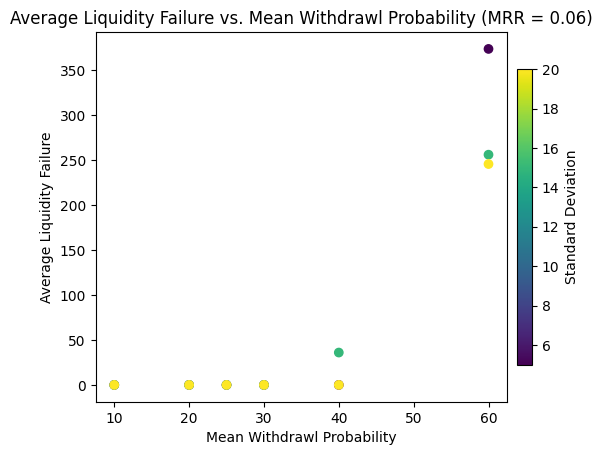

<Figure size 1200x1200 with 0 Axes>

In [102]:
plt.scatter(means_06, num_liquidity_failures_06, c=stds_06, cmap='viridis')
cbar = plt.colorbar(aspect=20, shrink=0.8, pad=0.02)
cbar.set_label('Standard Deviation')
plt.xlabel('Mean Withdrawl Probability')
plt.ylabel('Average Liquidity Failure')
plt.title('Average Liquidity Failure vs. Mean Withdrawl Probability (MRR = 0.06)')
plt.figure(figsize=(12, 12))

Text(0, 0.5, 'Average Liquidity Failure')

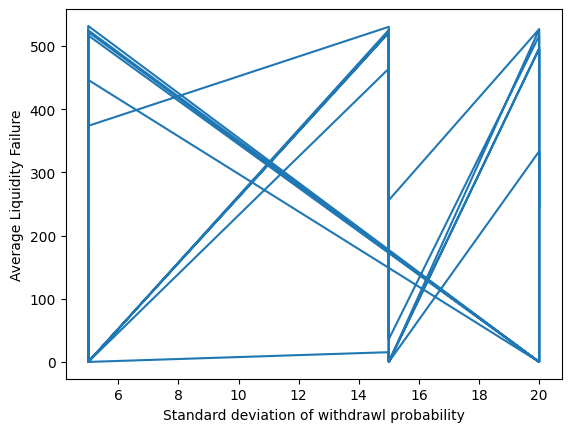

In [47]:
plt.plot(stds, num_liquidity_failures)
plt.xlabel('Standard deviation of withdrawl probability')
plt.ylabel('Average Liquidity Failure')

Text(0, 0.5, 'Average Liquidity Failure')

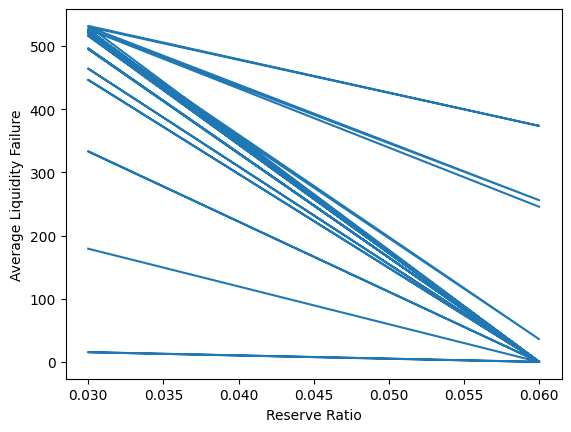

In [48]:
plt.plot(reserve_ratios, num_liquidity_failures)
plt.xlabel('Reserve Ratio')
plt.ylabel('Average Liquidity Failure')